# NLP Clissification
---
**Dataset:** bbc news (250 samples) News contents with 5 categories (Sport, Business, Politics, Tech and Others)

**Model:**   multiclass classification model : Logistic Regression

**Training:**  Colab (GPU)  

**Process:**  1. Dataset Load  ➔ 2. Data processing ➔ 3. Model Training  ➔ 4. Model Evaluation

**Result:**  Accuracy  = 0.84, run time = 1 minutes

## 0. Environment

In [ ]:
# Based Library
import tensorflow as tf; print("tensorflow version : " + tf.__version__)
import keras; print("keras version : " + keras.__version__)

tensorflow version : 1.14.0
keras version : 2.2.4


Using TensorFlow backend.


In [ ]:
# Processor

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2604255774281569294
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13119959655385616581
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16864474444624477676
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9943479092
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4159141692407593120
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


## 1. Dataset Load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# intent, unique_intent, sentencesに分ける
import pandas as pd

def load_dataset(filename):
  df = pd.read_csv(filename, encoding = "latin1", names = ["Sentence", "Intent"])
  print(df.head())
  intent = df["Intent"]
  unique_intent = list(set(intent))
  sentences = list(df["Sentence"])
  
  return (df, intent, unique_intent, sentences)

In [ ]:
# データ読み込

dataset = "/content/drive/My Drive/dataset/chat_intent1/Dataset.csv"
data, intent, unique_intent, sentences = load_dataset(dataset)

                Sentence          Intent
0       Need help pleese  commonQ.assist
1              Need help  commonQ.assist
2       I need some info  commonQ.assist
3      Will you help me?  commonQ.assist
4  What else can you do?  commonQ.assist


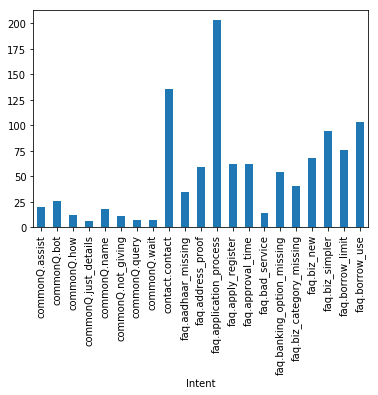

In [ ]:
import matplotlib.pyplot as plt

data.groupby('Intent').Sentence.count().plot.bar(ylim=0)
plt.show()

## 2. Data Processing

In [ ]:
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

nltk.download('stopwords')
stemmer = PorterStemmer()
words = stopwords.words("english")
data['cleaned'] = data['Intent'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data.head()

,Sentence,Intent,cleaned
0,Need help pleese,commonQ.assist,commonq assist
1,Need help,commonQ.assist,commonq assist
2,I need some info,commonQ.assist,commonq assist
3,Will you help me?,commonQ.assist,commonq assist
4,What else can you do?,commonQ.assist,commonq assist


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))
final_features = vectorizer.fit_transform(data['cleaned']).toarray()
final_features.shape

(1113, 56)

In [ ]:
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X = data['cleaned']
Y = data['Intent']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)

print("X_train count : ", len(X_train))
print("X_test count : ", len(X_test))

X_train count :  890
X_test count :  223


## 3. Model Training

In [ ]:
pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2, k=50)),
                     ('clf', LogisticRegression(random_state=0))])

model = pipeline.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


## 4. Model Evaluation

In [ ]:
with open('LogisticRegression.pickle', 'wb') as f:
    pickle.dump(model, f)

ytest = np.array(y_test)

# confusion matrix and classification report(precision, recall, F1-score)
print(classification_report(ytest, model.predict(X_test)))
print(confusion_matrix(ytest, model.predict(X_test)))

                            precision    recall  f1-score   support

            commonQ.assist       1.00      1.00      1.00         2
               commonQ.bot       1.00      1.00      1.00         7
               commonQ.how       0.00      0.00      0.00         2
              commonQ.name       0.00      0.00      0.00         0
        commonQ.not_giving       0.00      0.00      0.00         2
             commonQ.query       1.00      1.00      1.00         2
              commonQ.wait       1.00      1.00      1.00         1
           contact.contact       1.00      1.00      1.00        28
       faq.aadhaar_missing       1.00      1.00      1.00         7
         faq.address_proof       1.00      1.00      1.00        10
   faq.application_process       1.00      1.00      1.00        45
        faq.apply_register       1.00      1.00      1.00        11
         faq.approval_time       1.00      1.00      1.00        11
           faq.bad_service       1.00      1.00

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
